In [1]:
import os

import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sklearn
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

from yellowbrick.regressor import residuals_plot

import tensorflow as tf

import missingno as msno
import fancyimpute

In [2]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Load and Join Here - Move this to a separate notebook

Do all of this offline and save to bigger csvs

In [3]:
# Iterative Imputation
X_sj_filled_ii = pd.read_csv("../deng_features/X_sj_filled_ii.csv")
X_iq_filled_ii = pd.read_csv("../deng_features/X_iq_filled_ii.csv")
X_train_filled_ii = pd.concat([X_sj_filled_ii, X_iq_filled_ii])

X_test_sj_filled_ii = pd.read_csv("../deng_features/X_test_sj_filled_ii.csv")
X_test_iq_filled_ii = pd.read_csv("../deng_features/X_test_iq_filled_ii.csv")
X_test_filled_ii = pd.concat([X_test_sj_filled_ii, X_test_iq_filled_ii])

# Linear Interpolation
X_sj_filled_interp = pd.read_csv("../deng_features/X_sj_filled_interp.csv")
X_iq_filled_interp = pd.read_csv("../deng_features/X_iq_filled_interp.csv")
X_train_filled_interp = pd.concat([X_sj_filled_interp, X_iq_filled_interp])

X_test_sj_filled_interp = pd.read_csv("../deng_features/X_test_sj_filled_interp.csv")
X_test_iq_filled_interp = pd.read_csv("../deng_features/X_test_iq_filled_interp.csv")
X_test_filled_interp = pd.concat([X_test_sj_filled_interp, X_test_iq_filled_interp])

# Is_missing labels csv.
sj_is_missing = pd.read_csv("../deng_features/sj_is_missing.csv")
iq_is_missing = pd.read_csv("../deng_features/iq_is_missing.csv")

X_train_is_missing = pd.read_csv("../deng_features/X_train_is_missing.csv")
X_test_is_missing = pd.read_csv("../deng_features/X_test_is_missing.csv")

In [4]:
# Create a function: get_datasets with options

In [5]:
y_train = pd.read_csv("../dengue_labels_train.csv")

# Drop year
y_train.drop("year", axis = 1, inplace = True)

y_train_iq = y_train[y_train["city"] == "iq"]
y_train_sj = y_train[y_train["city"] == "sj"]


### Set train and test dfs here

#### Notes
* Iterative Imputed NDVI_NE did not improve score.


In [6]:
drop_cols = ["year", "ndvi_ne"]

X_train = pd.concat([X_sj_filled_interp, X_iq_filled_interp]).drop("Unnamed: 0", axis = 1)

# Join with is_missing ... Maybe do this only with MNAR cols?
# X_train = X_train.join(X_train_is_missing, on = X_train.index)

# Use the iteratively imputed dataframe for the ndvi_ne column
# X_train["ndvi_ne"] = X_train_filled_ii["ndvi_ne"]

# Drop year
X_train.drop(drop_cols, axis = 1, inplace = True)


####################Test #############################
X_test = X_test_filled_interp.drop("Unnamed: 0", axis = 1)

X_test.drop(drop_cols, axis = 1, inplace = True)

# Use the iteratively imputed dataframe for the ndvi_ne column
#X_test["ndvi_ne"] = X_test_filled_ii["ndvi_ne"]

# Join with is_missing
# X_test = X_test.join(X_test_is_missing, on = X_test.index)

In [7]:
feat_eng_path = "../join_these_csvs/"

train_first_diff = pd.read_csv(feat_eng_path + "train_first_diff.csv")
train_sec_diff = pd.read_csv(feat_eng_path + "train_sec_diff.csv")
train_pct_change = pd.read_csv(feat_eng_path + "train_pct_change.csv")

X_train = X_train.join(train_first_diff, on = X_train.index)
X_train = X_train.join(train_sec_diff, on = X_train.index)

# X_train = X_train.join(train_pct_change, on = X_train.index)


##########Test

test_first_diff = pd.read_csv(feat_eng_path + "test_first_diff.csv")
test_sec_diff = pd.read_csv(feat_eng_path + "test_sec_diff.csv")
test_pct_change = pd.read_csv(feat_eng_path + "test_pct_change.csv")

X_test = X_test.join(test_first_diff, on = X_test.index)
X_test = X_test.join(test_sec_diff, on = X_test.index)

# X_test = X_test.join(test_pct_change, on = X_test.index)

# FillNas with -999
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

X_train = X_train.interpolate(limit_direction = "both")
X_test = X_test.interpolate(limit_direction = "both")

In [8]:
X_train.shape

(1456, 60)

In [9]:
X_train.head()

,city,weekofyear,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_dd,reanalysis_relative_humidity_percent_dd,reanalysis_sat_precip_amt_mm_dd,reanalysis_specific_humidity_g_per_kg_dd,reanalysis_tdtr_k_dd,station_avg_temp_c_dd,station_diur_temp_rng_c_dd,station_max_temp_c_dd,station_min_temp_c_dd,station_precip_mm_dd
0,0,18,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,...,-999.00,-999.000000,-999.00,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.0
1,0,19,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,...,-999.00,-999.000000,-999.00,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.0
2,0,20,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,...,22.22,0.681429,1.32,0.115714,0.185714,-1.271429,0.642857,-1.8,-1.6,40.2
3,0,21,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,...,-20.36,-6.400000,-30.90,-1.651429,0.200000,0.757143,0.171429,0.6,-0.1,-70.2
4,0,22,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,...,10.50,1.838571,11.34,0.712857,0.457143,0.714286,2.314286,0.6,0.1,39.2


In [10]:
X_test.tail()

,city,weekofyear,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_dd,reanalysis_relative_humidity_percent_dd,reanalysis_sat_precip_amt_mm_dd,reanalysis_specific_humidity_g_per_kg_dd,reanalysis_tdtr_k_dd,station_avg_temp_c_dd,station_diur_temp_rng_c_dd,station_max_temp_c_dd,station_min_temp_c_dd,station_precip_mm_dd
151,1,22,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,...,14.90,11.874286,10.56,2.648571,0.300000,0.342857,1.900000,1.700000e+00,-1.0,10.7
152,1,23,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,...,-16.24,0.784286,15.13,0.485714,-0.285714,0.471429,-0.285714,6.000000e-01,0.5,-9.0
153,1,24,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,...,-3.32,-6.174286,-28.36,-0.900000,0.314286,0.671429,0.057143,-7.105427e-15,1.1,-8.0
154,1,25,0.302700,0.406614,0.403943,39.54,295.778571,297.400000,293.648571,305.9,...,0.06,-5.631429,11.33,-2.101429,-0.328571,-2.285714,-1.642857,-3.900000e+00,-1.1,9.7
155,1,26,0.240071,0.356943,0.273600,51.80,297.372857,299.000000,294.615714,307.3,...,17.50,9.012857,33.87,1.697143,-0.371429,0.871429,0.100000,1.000000e+00,0.5,14.1


In [11]:
X_test.shape

(416, 60)

In [12]:
X_train_orig = pd.read_csv("../dengue_features_train.csv")
y_train_orig = pd.read_csv("../dengue_labels_train.csv")
X_test_orig = pd.read_csv("../dengue_features_test.csv")

# Quick Date Feature Engineering
# X_train['month'] = pd.DatetimeIndex(X_train['week_start_date']).month
# X_train['day'] = pd.DatetimeIndex(X_train['week_start_date']).day

# X_test['month'] = pd.DatetimeIndex(X_test['week_start_date']).month
# X_test['day'] = pd.DatetimeIndex(X_test['week_start_date']).day

# Load particular joins you want to use.

# EDIT - make sure these splits happen on the customized joins you want to use.

X_test_sj = X_test[X_test.city == 0]
X_test_iq = X_test[X_test.city == 1]

# Create separate df's for different cities to prevent 'concept drift'
X_train_sj = X_train[X_train.city == 0]
X_train_iq = X_train[X_train.city == 1]

submission_format = pd.read_csv("../submission_format.csv")

## Validate Inputs

In [13]:
X_train_sj.head()

,city,weekofyear,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_dd,reanalysis_relative_humidity_percent_dd,reanalysis_sat_precip_amt_mm_dd,reanalysis_specific_humidity_g_per_kg_dd,reanalysis_tdtr_k_dd,station_avg_temp_c_dd,station_diur_temp_rng_c_dd,station_max_temp_c_dd,station_min_temp_c_dd,station_precip_mm_dd
0,0,18,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,...,-999.00,-999.000000,-999.00,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.0
1,0,19,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,...,-999.00,-999.000000,-999.00,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.0
2,0,20,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,...,22.22,0.681429,1.32,0.115714,0.185714,-1.271429,0.642857,-1.8,-1.6,40.2
3,0,21,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,...,-20.36,-6.400000,-30.90,-1.651429,0.200000,0.757143,0.171429,0.6,-0.1,-70.2
4,0,22,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,...,10.50,1.838571,11.34,0.712857,0.457143,0.714286,2.314286,0.6,0.1,39.2


In [14]:
y_train_sj.head()

,city,weekofyear,total_cases
0,sj,18,4
1,sj,19,5
2,sj,20,4
3,sj,21,3
4,sj,22,6


In [15]:
X_train_iq.head()

,city,weekofyear,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_dd,reanalysis_relative_humidity_percent_dd,reanalysis_sat_precip_amt_mm_dd,reanalysis_specific_humidity_g_per_kg_dd,reanalysis_tdtr_k_dd,station_avg_temp_c_dd,station_diur_temp_rng_c_dd,station_max_temp_c_dd,station_min_temp_c_dd,station_precip_mm_dd
0,1,26,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,295.184286,307.3,...,-999.00,-999.000000,-999.00,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.0
1,1,27,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,295.358571,306.6,...,-999.00,-999.000000,-999.00,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.0
2,1,28,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,295.622857,304.5,...,22.22,0.681429,1.32,0.115714,0.185714,-1.271429,0.642857,-1.8,-1.6,40.2
3,1,29,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,292.797143,303.6,...,-20.36,-6.400000,-30.90,-1.651429,0.200000,0.757143,0.171429,0.6,-0.1,-70.2
4,1,30,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,293.957143,307.0,...,10.50,1.838571,11.34,0.712857,0.457143,0.714286,2.314286,0.6,0.1,39.2


In [16]:
y_train_iq.reset_index(drop = True, inplace = True)
y_train_iq.head()

,city,weekofyear,total_cases
0,iq,26,0
1,iq,27,0
2,iq,28,0
3,iq,29,0
4,iq,30,0


In [17]:
print(X_train_sj.shape,
     y_train_sj.shape,
     X_train_iq.shape,
     y_train_iq.shape)

(936, 60) (936, 3) (520, 60) (520, 3)


## Time Series Splits

In the test set, there are a few years of a gap between the training and test set.
The validation set should 'mimick this' by skipping a year?


In [18]:
# X_iq = X_iq.reset_index()

In [19]:
X_train_iq.iloc[457:461]

,city,weekofyear,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_dd,reanalysis_relative_humidity_percent_dd,reanalysis_sat_precip_amt_mm_dd,reanalysis_specific_humidity_g_per_kg_dd,reanalysis_tdtr_k_dd,station_avg_temp_c_dd,station_diur_temp_rng_c_dd,station_max_temp_c_dd,station_min_temp_c_dd,station_precip_mm_dd
457,1,16,0.178829,0.175000,0.216143,99.77,296.635714,297.621429,296.135714,304.7,...,15.65,7.915714,0.00,1.955714,-0.314286,-0.057143,2.514286,0.5,0.1,-24.5
458,1,17,0.285671,0.161186,0.202386,52.74,297.545714,298.278571,296.887143,303.6,...,24.14,9.161429,18.66,2.235714,0.742857,1.700000,-1.614286,1.6,3.2,37.0
459,1,18,0.345514,0.237443,0.316129,99.89,297.404286,298.321429,296.448571,303.6,...,-23.88,-11.598571,-13.42,-3.592857,-0.514286,-1.214286,-0.742857,-2.1,-2.1,-46.7
460,1,19,0.264557,0.253886,0.219200,30.73,297.562857,298.542857,296.484286,306.8,...,9.54,9.170000,-29.14,3.970000,-0.071429,1.242857,1.142857,1.0,2.2,64.9


In [20]:
X_train_sj.shape

(936, 60)

In [21]:
X_train_sj.iloc[832:834]

,city,weekofyear,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_dd,reanalysis_relative_humidity_percent_dd,reanalysis_sat_precip_amt_mm_dd,reanalysis_specific_humidity_g_per_kg_dd,reanalysis_tdtr_k_dd,station_avg_temp_c_dd,station_diur_temp_rng_c_dd,station_max_temp_c_dd,station_min_temp_c_dd,station_precip_mm_dd
832,0,17,0.03510,0.115886,0.086786,103.35,298.898571,299.192857,294.438571,302.0,...,-17.67,-3.111429,26.47,-0.332857,-0.128571,-1.200000,-0.128571,0.0,-0.6,112.7
833,0,18,0.04355,0.120900,0.095657,54.47,298.872857,299.192857,294.727143,302.2,...,3.70,2.914286,-91.37,0.324286,-0.057143,0.557143,-0.085714,0.5,-0.6,-78.9


In [22]:
X_test_sj.head()

,city,weekofyear,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_dd,reanalysis_relative_humidity_percent_dd,reanalysis_sat_precip_amt_mm_dd,reanalysis_specific_humidity_g_per_kg_dd,reanalysis_tdtr_k_dd,station_avg_temp_c_dd,station_diur_temp_rng_c_dd,station_max_temp_c_dd,station_min_temp_c_dd,station_precip_mm_dd
0,0,18,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,...,-999.00,-999.000000,-999.00,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.0
1,0,19,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,...,-14.17,0.591429,57.14,1.010000,2.414286,2.314286,3.728571,6.1,0.1,9.6
2,0,20,-0.016133,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,...,-14.17,0.591429,57.14,1.010000,2.414286,2.314286,3.728571,6.1,0.1,9.6
3,0,21,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,...,15.79,-5.294286,5.24,-1.781429,-1.942857,-1.728571,-3.742857,-2.3,1.0,28.6
4,0,22,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,...,4.08,6.322857,4.42,1.260000,-0.714286,-0.571429,2.328571,-0.5,-2.7,86.5


In [23]:
# id 355 in X_iq is on the 18th week.  Which corresponds to the test set/

iq_id_split = 459

iquitos_train_split_X = X_train_iq.iloc[:iq_id_split].reset_index(drop = True)
iquitos_train_split_y = y_train_iq.iloc[:iq_id_split].total_cases.reset_index(drop = True)

iquitos_valid_split_X = X_train_iq.iloc[iq_id_split:].reset_index(drop = True)
iquitos_valid_split_y = y_train_iq.iloc[iq_id_split:].total_cases.reset_index(drop = True)

print(iquitos_train_split_X.shape,
     iquitos_train_split_y.shape,
     iquitos_valid_split_X.shape,
     iquitos_valid_split_y.shape)


(459, 60) (459,) (61, 60) (61,)


In [24]:
# id 833 is on the 18th week.

sj_id_split = 833

sj_train_split_X = X_train_sj.iloc[:sj_id_split].reset_index(drop = True)
sj_train_split_y = y_train_sj.iloc[:sj_id_split].total_cases.reset_index(drop = True)

sj_valid_split_X = X_train_sj.iloc[sj_id_split:].reset_index(drop = True)
sj_valid_split_y = y_train_sj.iloc[sj_id_split:].total_cases.reset_index(drop = True)

print(sj_train_split_X.shape,
     sj_train_split_y.shape,
     sj_valid_split_X.shape,
     sj_valid_split_y.shape)

(833, 60) (833,) (103, 60) (103,)


## Tree based modeling

In [25]:
# Create a function here with estimators

In [26]:
iq_extra_params = {}

extra_reg = ExtraTreesRegressor(n_estimators = 300,
                                criterion = "mae",
                                ccp_alpha = 0.10)

extra_reg.fit(iquitos_train_split_X, iquitos_train_split_y)

iq_ex_preds = extra_reg.predict(iquitos_valid_split_X)

print("MAE: ", mean_absolute_error(iquitos_valid_split_y, iq_ex_preds))

MAE:  3.533169398907104


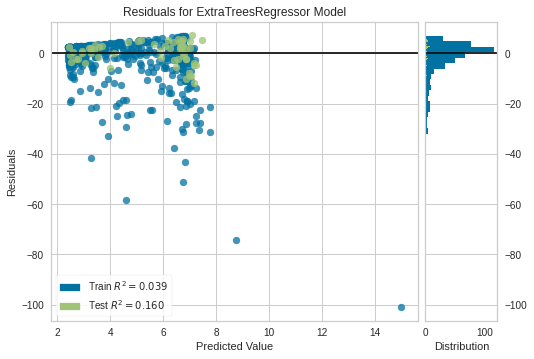

In [27]:
viz = residuals_plot(extra_reg, iquitos_train_split_X, iquitos_train_split_y, iquitos_valid_split_X, iquitos_valid_split_y)


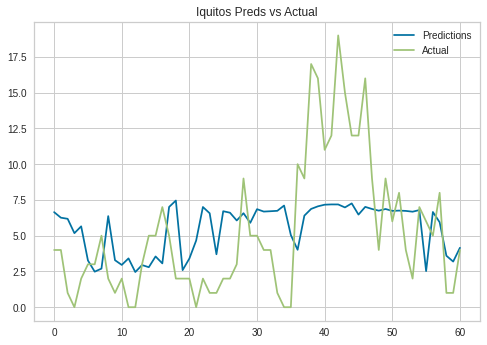

In [28]:
plt.plot(iq_ex_preds, label = "Predictions")
plt.plot(iquitos_valid_split_y, label = "Actual")

plt.title("Iquitos Preds vs Actual")

plt.legend()
plt.show()

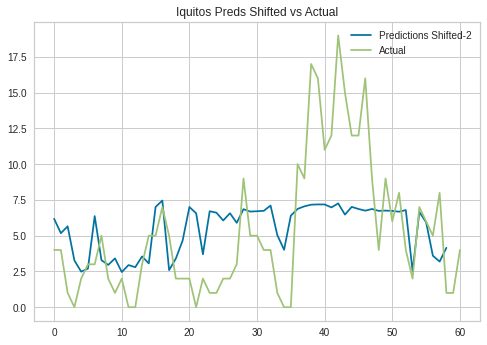

In [29]:
plt.plot(pd.Series(iq_ex_preds).shift(-2), label = "Predictions Shifted-2")

plt.plot(iquitos_valid_split_y, label = "Actual")

plt.title("Iquitos Preds Shifted vs Actual")

plt.legend()
plt.show()

## Prediction San Juan

In [30]:
sj_ex_params = {}

extra_reg = ExtraTreesRegressor(n_estimators = 300,
                                criterion = "mae",
                                ccp_alpha = 0.3)

extra_reg.fit(sj_train_split_X, sj_train_split_y)

sj_ex_preds = extra_reg.predict(sj_valid_split_X)

print("MAE: ", mean_absolute_error(sj_valid_split_y, sj_ex_preds))

MAE:  17.65716828478964


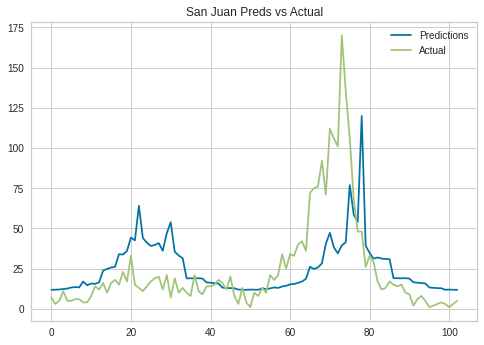

In [31]:
plt.plot(sj_ex_preds, label = "Predictions")
plt.plot(sj_valid_split_y, label = "Actual")
plt.title("San Juan Preds vs Actual")
plt.legend()
plt.show()

## Create Submission Pred - Shift 2 back

In [32]:
# Prediction for San Juan

extra_reg_sub = ExtraTreesRegressor(n_estimators = 300,
                                criterion = "mae",
                                ccp_alpha = 0.3)

extra_reg_sub.fit(X_train_sj, y_train_sj.total_cases)

ExtraTreesRegressor(ccp_alpha=0.3, criterion='mae', n_estimators=300)

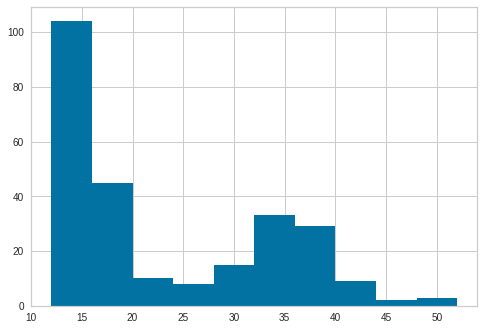

In [33]:
preds_sj_sub = extra_reg_sub.predict(X_test_sj)
preds_sj_sub = np.around(preds_sj_sub).astype(int)
preds_sj_sub = pd.Series(preds_sj_sub).shift(-2)
plt.hist(preds_sj_sub)
plt.show()

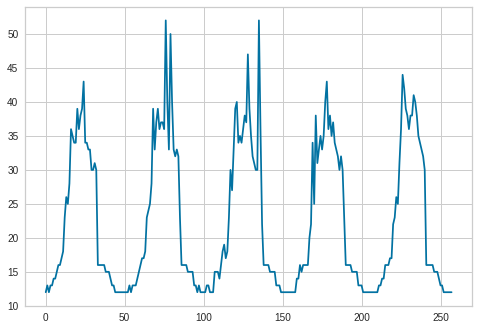

In [34]:
plt.plot(preds_sj_sub)

In [35]:
sj_subs = pd.DataFrame(preds_sj_sub, columns = ["total_cases"])
sj_subs.to_csv("../deng_predictions/sj_extra_preds.csv", index = False)

## Iquitos Predictions